# Peer-graded Assignment: Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats, special
import itertools
import warnings
from tqdm import tqdm
sns.set(rc={'figure.figsize': (15, 10)})

In [5]:
data = pd.read_csv('salary.csv', sep=';', names=['date', 'salary'], 
                   parse_dates=['date'], dayfirst=True, index_col=['date'], header=0)
data.head()

,salary
date,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


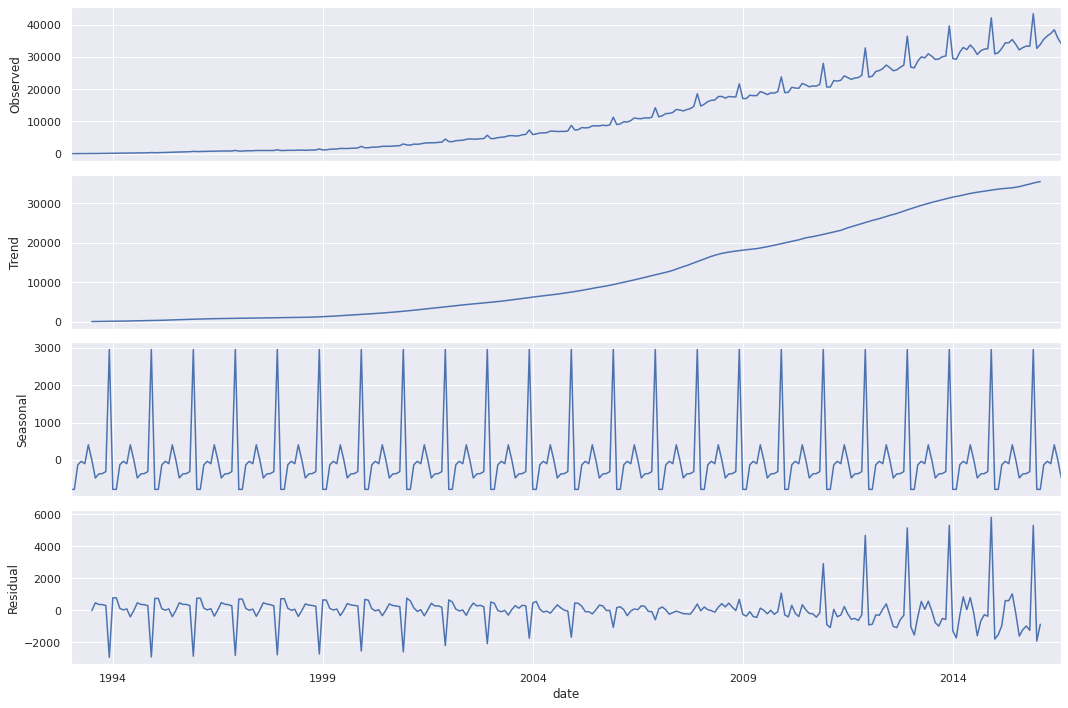

In [6]:
# Посмотрим на STL декомпозицию ряда
sm.tsa.seasonal_decompose(data.salary).plot();

Ряд явно не стационарен, в данных виден ярко выраженный возрастающий тренд и сезонность. Также дисперсия ряда меняется со временем, поэтому стоит применить преобразование Бокса-Кокса.

In [7]:
# Проверим ряд на стационарность с помощью критерия Дики-Фуллера
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(data.salary)[1], 4)}')

p-value критерия Дики-Фуллера: 0.9918


Как и ожидалось, гипотеза о нестационарности не отвергается.

In [8]:
# Применим преобразование Бокса-Кокса
transformed, lmbda = stats.boxcox(data.salary)
print(f'Автоматически найденный показатель lambda: {round(lmbda, 4)}')

Автоматически найденный показатель lambda: 0.2632


p-value критерия Дики-Фуллера: 0.6969


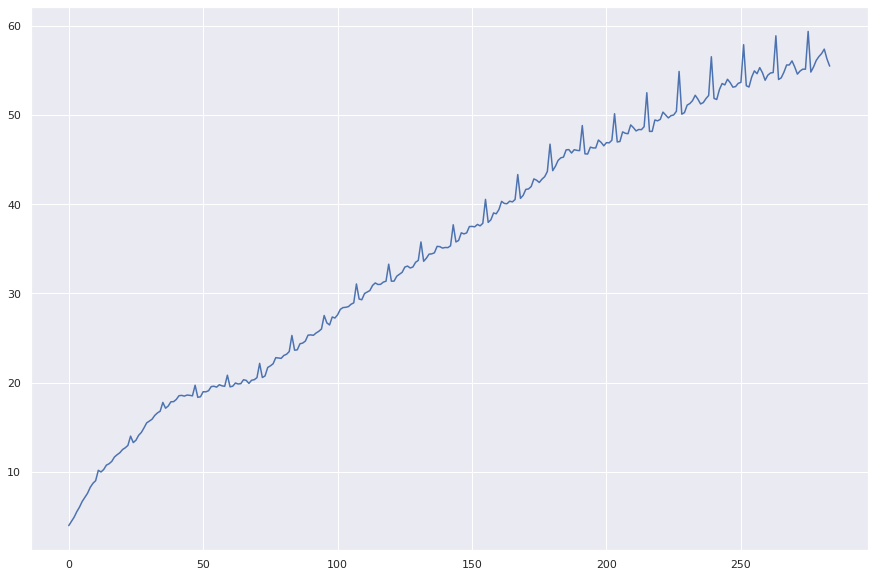

In [9]:
# Посмотрим на получившийся график
plt.plot(transformed);
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(transformed)[1], 4)}')

Похоже, что автоматический подбор не справился с задачей, дисперсия всё ещё увеличивается ближе к концу. Попробуем подобрать несколько значений.

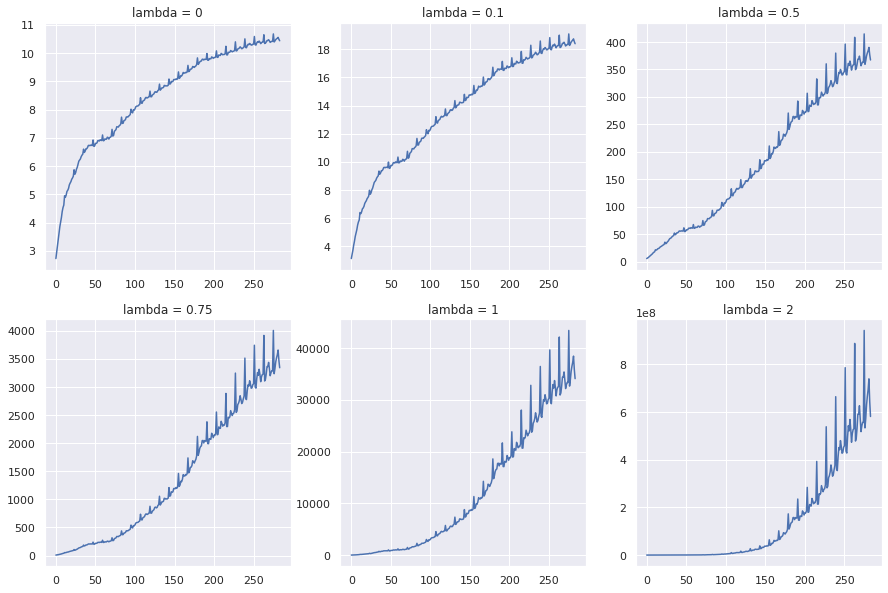

In [10]:
lmbdas = [0, 0.1, 0.5, 0.75, 1, 2]
for i, lmbda in enumerate(lmbdas):
    plt.subplot(2, 3, i+1)
    plt.plot(stats.boxcox(data.salary, lmbda=lmbda))
    plt.title(f'lambda = {lmbda}')

На мой взгляд, адекватнее всего выглядит вверсия с lambda = 0, поэтому остановлюсь на нём.

p-value критерия Дики-Фуллера: 0.034


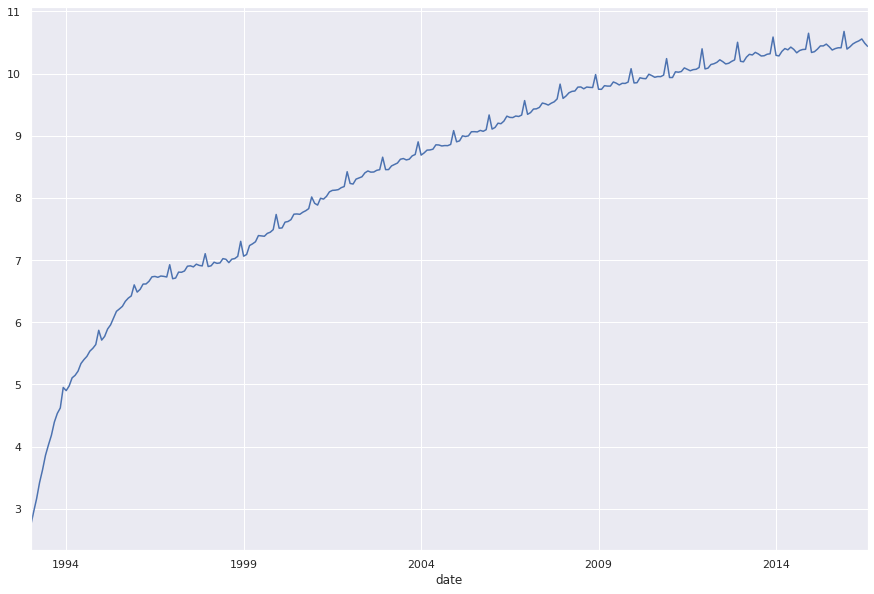

In [11]:
lmbda = 0
transformed0 = stats.boxcox(data.salary, lmbda=lmbda)
data['transformed'] = transformed0
data.transformed.plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(data.transformed)[1], 4)}')

Видим, что дисперсия стала более менее равной на всех участках. Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визульно в данных есть тренд. Чтобы избавиться от нестационарности попробуем сначала сделать сезонное дифференцирование ряда.

p-value критерия Дики-Фуллера: 0.0079


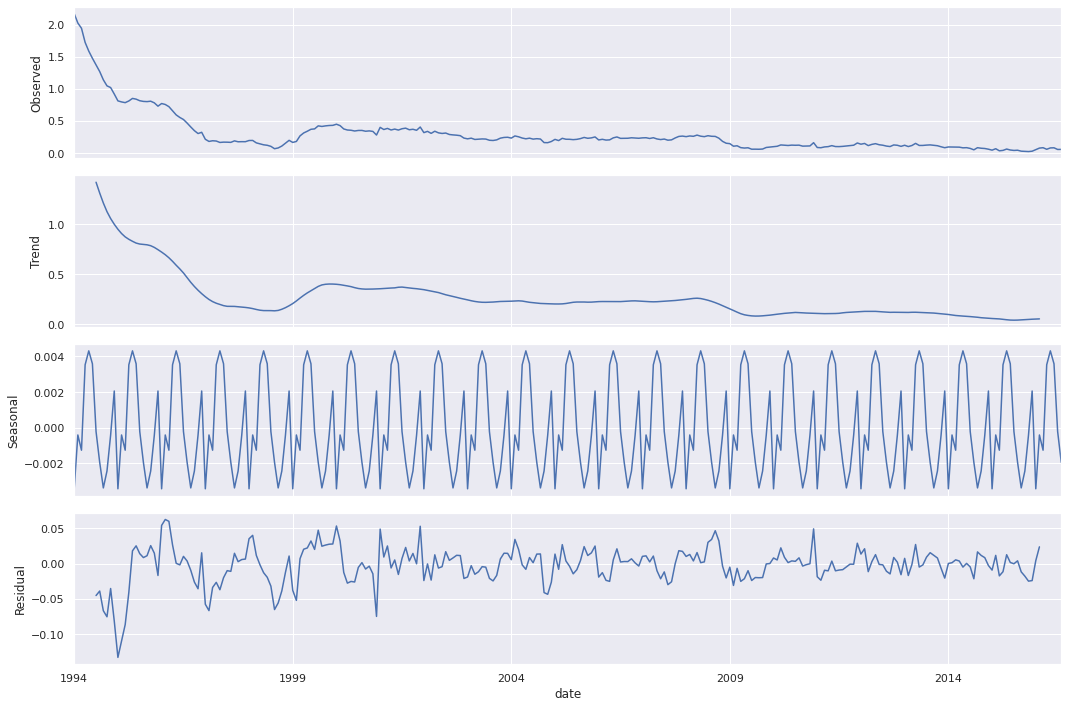

In [12]:
# Делаем сезонное дифференцирование ряда
data['D1'] = data.transformed - data.transformed.shift(12)
sm.tsa.seasonal_decompose(data['D1'].dropna()).plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(data.D1.dropna())[1], 4)}')

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визульно в данных остался какой-то тренд. Поэтому попробуем сделать ещё одно дифференцирование, в этот раз обычное.

p-value критерия Дики-Фуллера: 0.0107


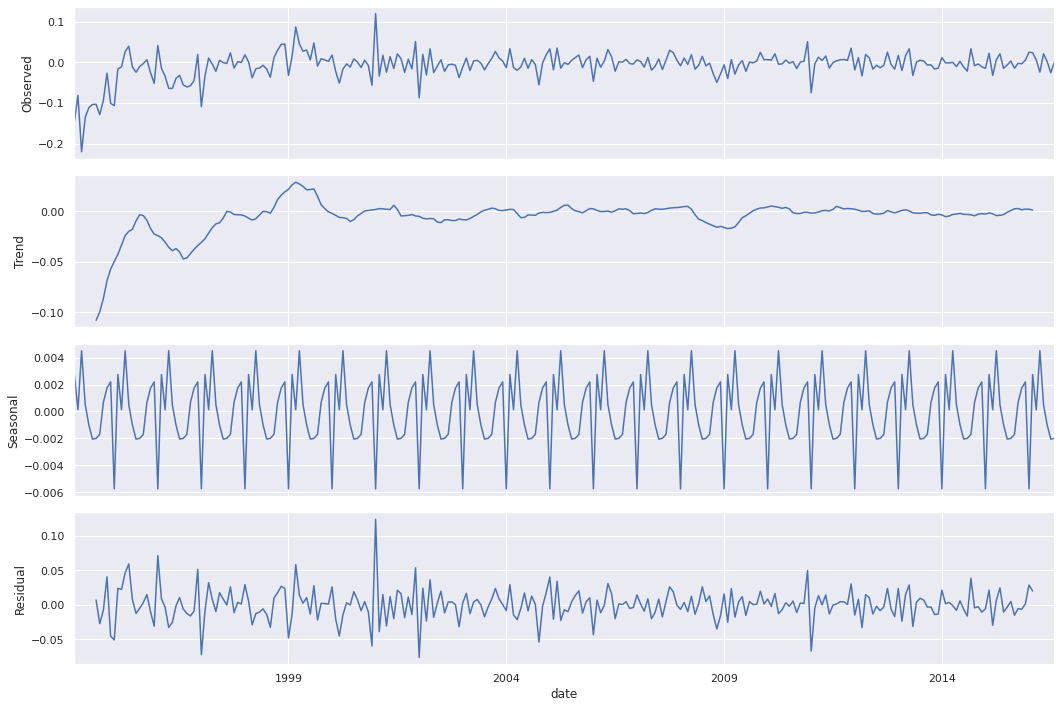

In [13]:
# Ещё раз дифференцируем
data['D1_d1'] = data.D1 - data.D1.shift(1)
sm.tsa.seasonal_decompose(data.D1_d1.dropna()).plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(data.D1_d1.dropna())[1], 4)}')

В целом неплохо, но в самом начале ещё что-то осталось. Можно было бы выкинуть эту часть данных, но попробуем ещё раз продифференцировать.

p-value критерия Дики-Фуллера: 6.986521150247654e-15


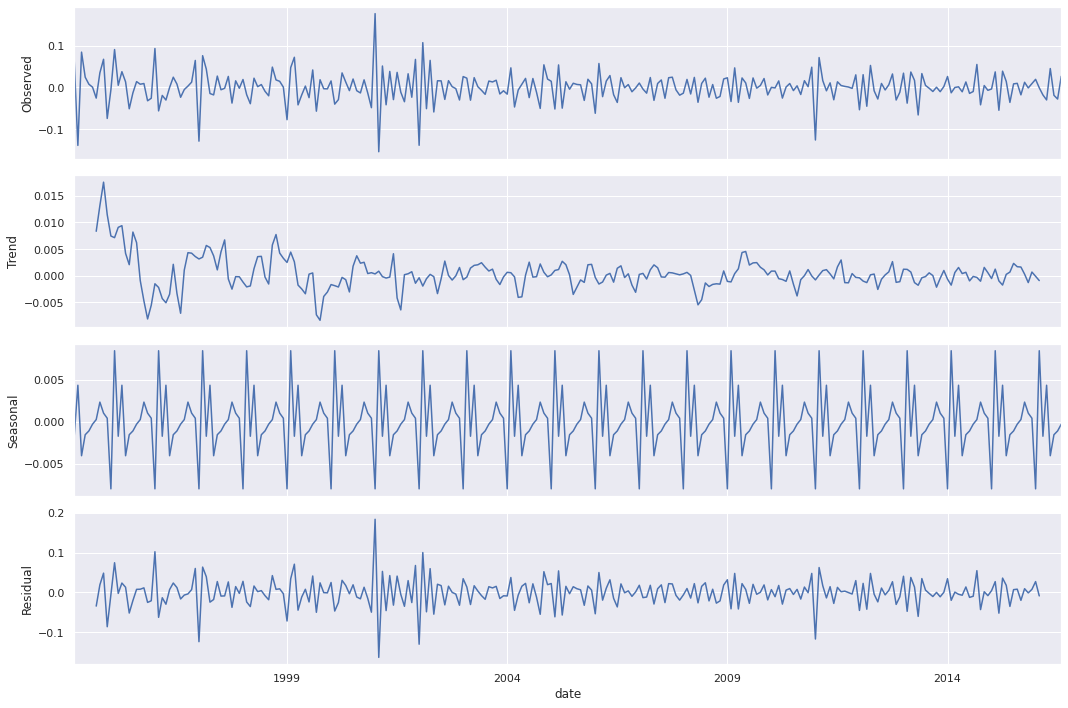

In [14]:
# И ещё раз дифференцируем
data['D1_d2'] = data.D1_d1 - data.D1_d1.shift(1)
sm.tsa.seasonal_decompose(data.D1_d2.dropna()).plot();
print(f'p-value критерия Дики-Фуллера: {sm.tsa.stattools.adfuller(data.D1_d2.dropna())[1]}')

Теперь тренд похоже в среднем равен нулю, и вообще всё выглядит как случайный шум. Критерий Дики-Фуллера очень уверенно отвергает гипотезу о нестационарности. Теперь можем считать ряд стационарным и зафиксировать гиперпараметры **D=1** и **d=2**

Теперь будем подбирать начальные приближения для гиперпараметров Q и q по графику автокорреляции.

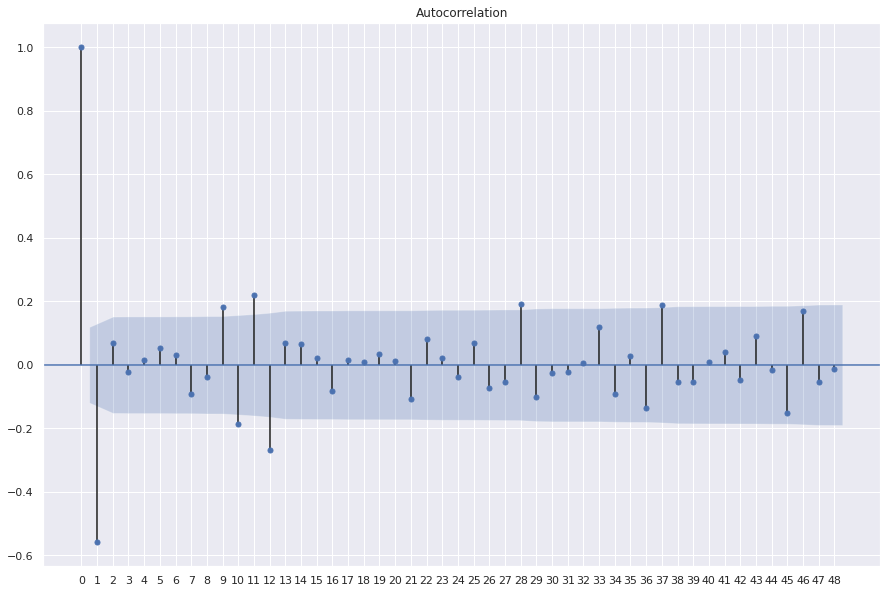

In [15]:
sm.graphics.tsa.plot_acf(data.D1_d2.dropna(), lags=48);
plt.xticks(range(49));

Последний значимый сезонный лаг равен 12, поэтому в качестве начального приближения возьмём **Q=1**, а несезонный равен 11, следовательно, **q=11**.

Построим график частичной автокорреляции для выбора начальных приближений P и p.

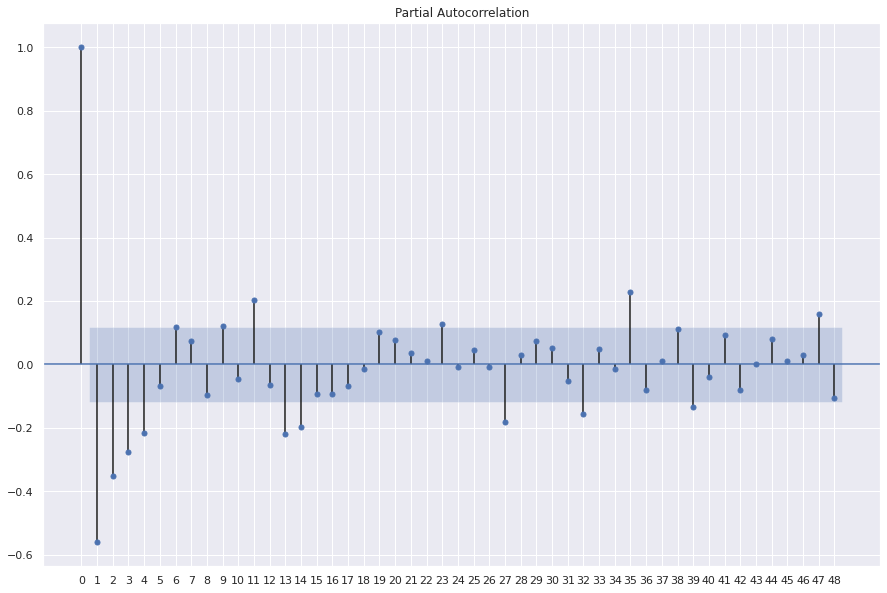

In [16]:
sm.graphics.tsa.plot_pacf(data.D1_d2.dropna(), lags=48);
plt.xticks(range(49));

На графике нет ни одного значимого сезонного лага, значит выбираем **P=0**, а начальное приближение для p выберем **p=11**, иначе модель будет очень большой, если взять p=47 на этом графике.

Создадим список параметров для перебора и будем сравнивать модели по критерию Акаике. Для начала ограничим перебор p до 4, а q до 1. Если выбрать приближения, которые мы получаем по графикам, модели будут строиться очень долго. Если окажется, что нашего перебора недостаточно, то есть модель будет плохой, то начнём перебор уже с найденными значениями.

In [17]:
D = 1
d = 2
Qs = range(2)
qs = range(12)
Ps = range(1)
ps = range(12)

In [ ]:
params = itertools.product(ps, qs, Ps, Qs)
params_list = list(params)
len(params_list)

288

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(params_list):
    model = sm.tsa.statespace.SARIMAX(data.transformed, order=(param[0], d, param[1]), 
                                    seasonal_order=(param[2], D, param[3], 12), enforce_stationarity=False,
                                    enforce_invertibility=False, trend='c').fit()
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, aic])

warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
29,"(1, 2, 0, 1)",-1208.270783
269,"(11, 2, 0, 1)",-1207.469021
5,"(0, 2, 0, 1)",-1206.687375
101,"(4, 2, 0, 1)",-1205.830255
7,"(0, 3, 0, 1)",-1205.395526


Лучшие параметры для модели получились p=1, d=2, q=2, P=0, D=1, Q=1. Модель с p=11 показала чуть худшие результаты, поэтому, скорее всего, проверять p=47 нет смысла.

In [ ]:
# Посмотрим на лучшую модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        transformed   No. Observations:                  284
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 12)   Log Likelihood                 610.135
Date:                            Thu, 06 Aug 2020   AIC                          -1208.271
Time:                                    16:13:18   BIC                          -1187.023
Sample:                                01-01-1993   HQIC                         -1199.724
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.694      0.488      -0.000       0.000
ar.L1          0.2355      0.165   

Критерий Льюнга-Бокса отвергает гипотезу о неавтокоррелированности остатков, что плохо. Давайте посмотрим на них.

Критерий Стьюдента: p=0.3883767670730309
Критерий Дики-Фуллера: p=2.904342633905668e-25


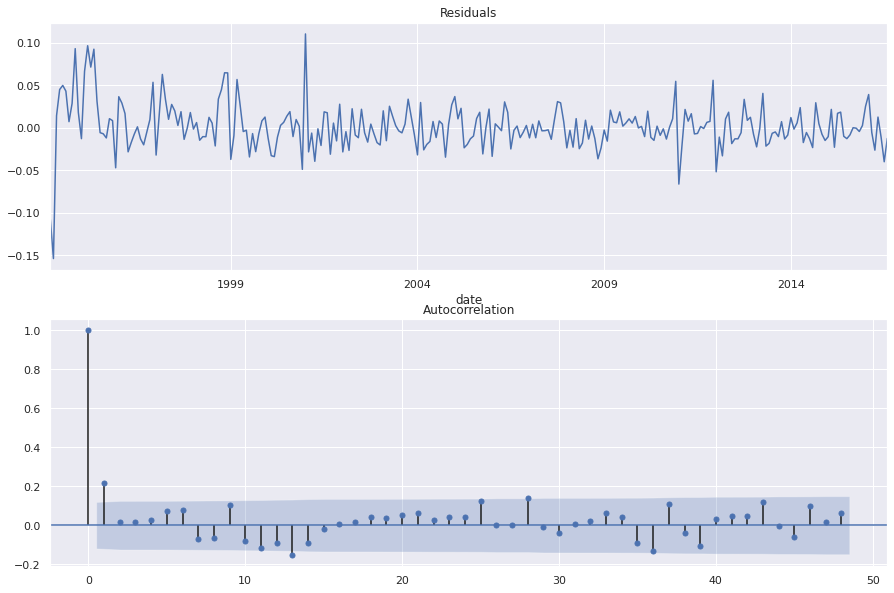

In [ ]:
plt.subplot(2, 1, 1)
best_model.resid[14:].plot();
plt.title('Residuals')
ax = plt.subplot(2, 1, 2)
sm.tsa.graphics.plot_acf(best_model.resid[14:], lags=48, ax=ax);
print(f'Критерий Стьюдента: p={stats.ttest_1samp(best_model.resid[14:], 0)[1]}')
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(best_model.resid[14:])[1]}')

Критерий Стьюдента говорит о том, что остатки несмещены, а критерий Дики-Фуллера, что остатки стационарны. На коррелограмме видно, что самый первый лаг достаточно значим. Мне кажется, что можно его проигнорировать, потому что действительно в самом начале наших данных очень сложная зависимость, которую скорее всего модель не может уловить полностью, но это не должно повлиять на прогнозы. Я бы вообще предложил выкинуть из данных самое начало и строить модель без него, должно стать лучше. Но посмотрим, как эта модель описывает наши данные.

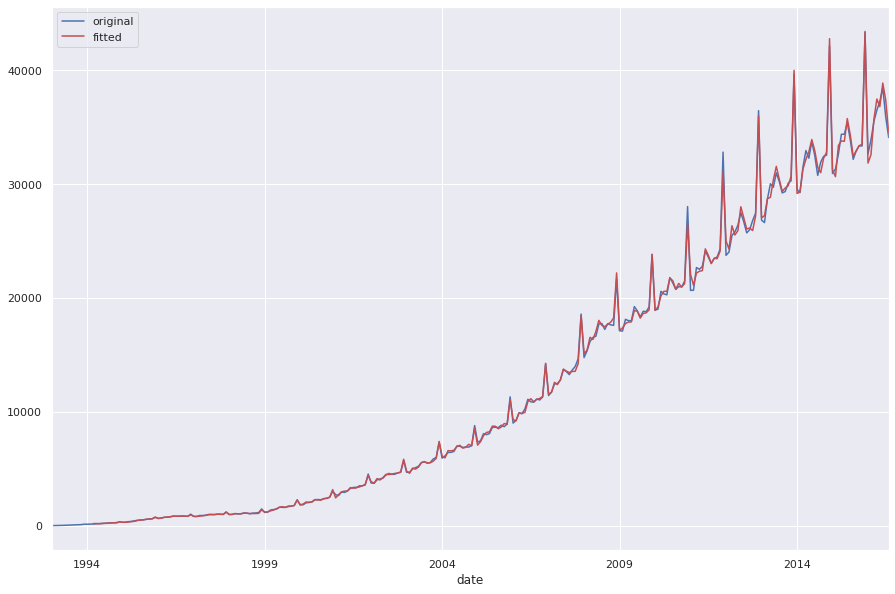

In [ ]:
data.salary.plot(label='original')
# Теперь в scipy есть функция обратного преобразования Бокса-Кокса
special.inv_boxcox(best_model.fittedvalues[14:], lmbda).plot(color='r', label='fitted')
plt.legend();

Модель достаточно хорошо описывает данные. Теперь попробуем построить прогноз до настоящего 2020 года.

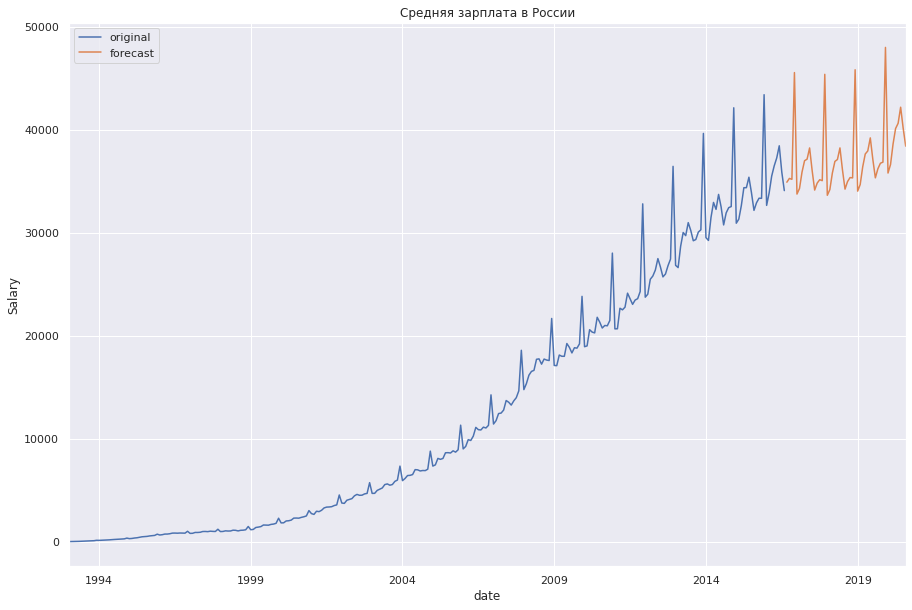

In [ ]:
start = data.index[-1] + pd.DateOffset(months=1)
end = pd.to_datetime('01.08.2020', dayfirst=True)
predictions = special.inv_boxcox(best_model.predict(start=start, end=end), lmbda)
data.salary.plot(label='original')
predictions.plot(label='forecast')
plt.title('Средняя зарплата в России')
plt.ylabel('Salary')
plt.legend();

Посмотрим, сходится ли это с реальностью. Данные взяты по ссылке в задании.

In [ ]:
dates = pd.date_range(start=start, end=pd.to_datetime('01.05.2020', dayfirst=True), freq='MS')
new_salary = pd.read_csv('new.txt', header=None)
new_salary.index = dates
new_salary.columns = ['new_salary']
new_salary.rename_axis(index='date', inplace=True)

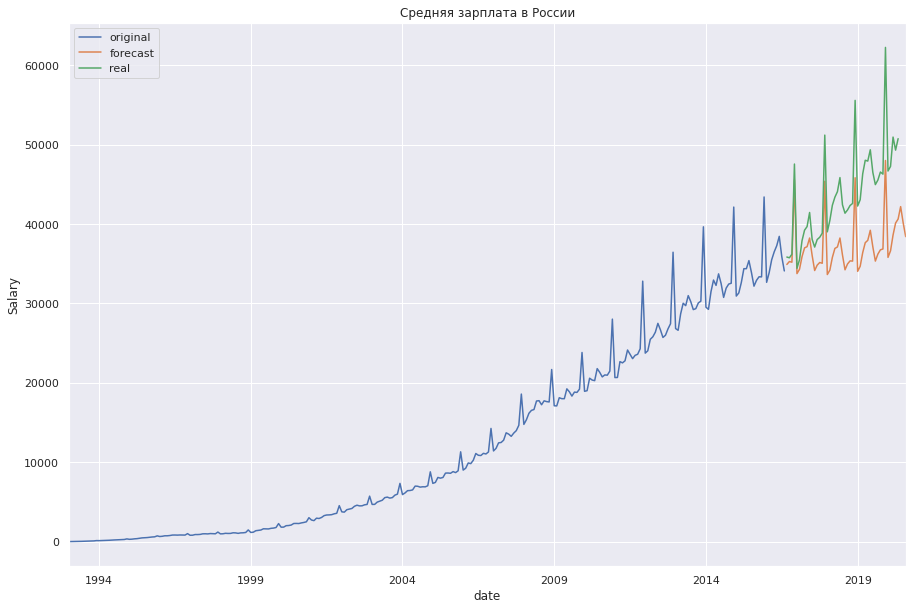

In [ ]:
data.salary.plot(label='original')
predictions.plot(label='forecast')
new_salary.new_salary.plot(label='real', color='g')
plt.title('Средняя зарплата в России')
plt.ylabel('Salary')
plt.legend();

Видно, что, к сожалению, модель не уловила тренд и сильно отличается от реальных данных. В качестве дополнения можно проверить как себя поведёт модель, если выбросить первую часть данных. Отрежем данные до 1999 года и проделаем всё то же самое.

In [59]:
truncated_data = pd.DataFrame(data.salary[72:])
truncated_data

,salary
date,
1999-01-01,1167.0
1999-02-01,1199.0
1999-03-01,1385.0
1999-04-01,1423.0
1999-05-01,1472.0
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


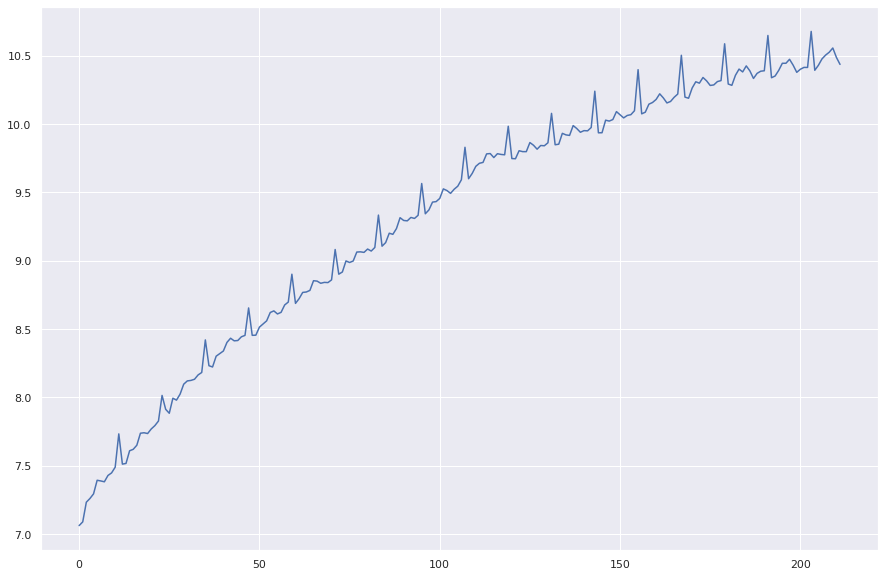

In [62]:
t = stats.boxcox(truncated_data.salary, 0)
plt.plot(t);

p-value критерия Дики-Фуллера: 0.0568


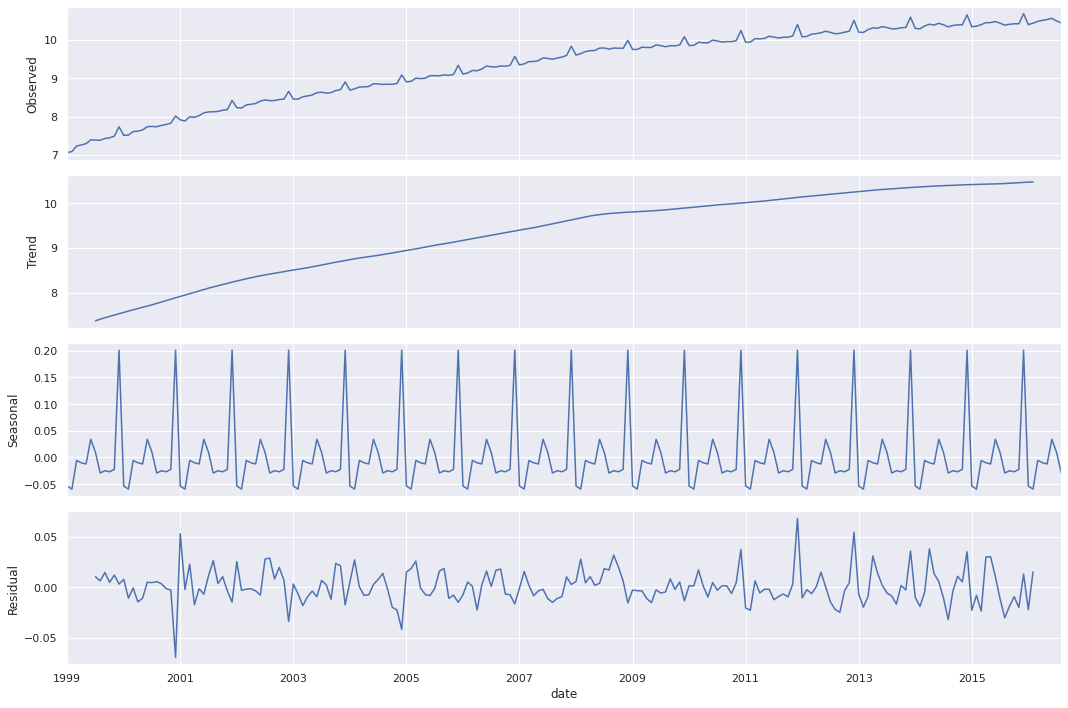

In [65]:
truncated_data['t'] = t
sm.tsa.seasonal_decompose(truncated_data.t).plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(truncated_data.t)[1], 4)}')

p-value критерия Дики-Фуллера: 0.4002


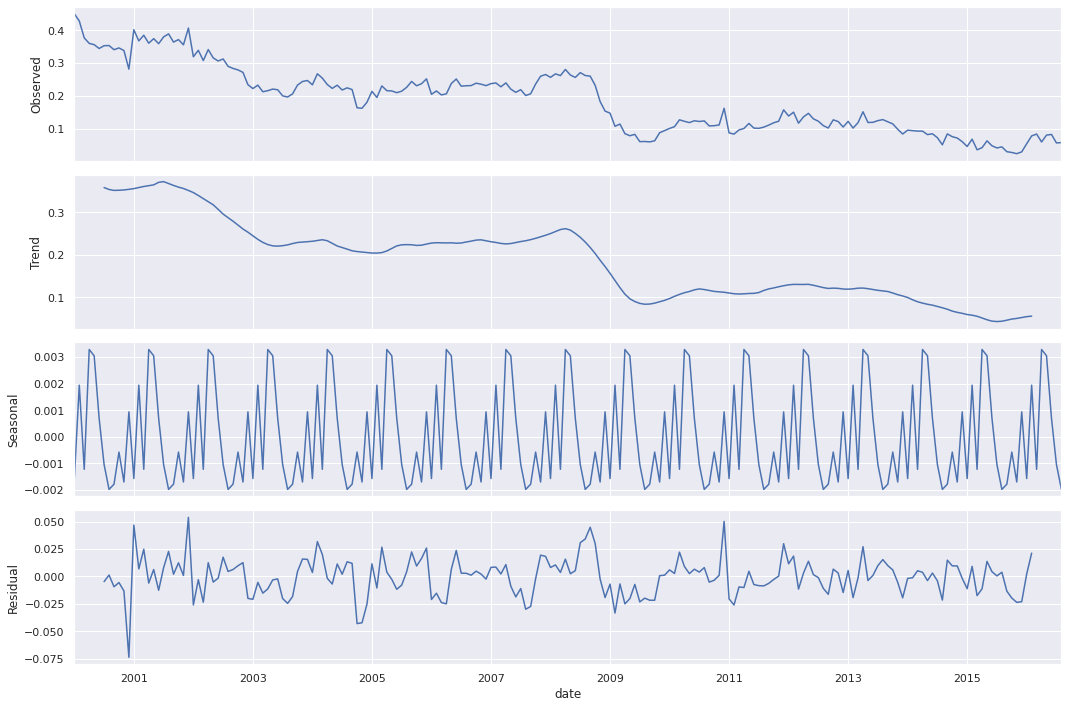

In [66]:
# Делаем сезонное дифференцирование ряда
truncated_data['D1'] = truncated_data.t - truncated_data.t.shift(12)
sm.tsa.seasonal_decompose(truncated_data['D1'].dropna()).plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(truncated_data.D1.dropna())[1], 4)}')

p-value критерия Дики-Фуллера: 0.0


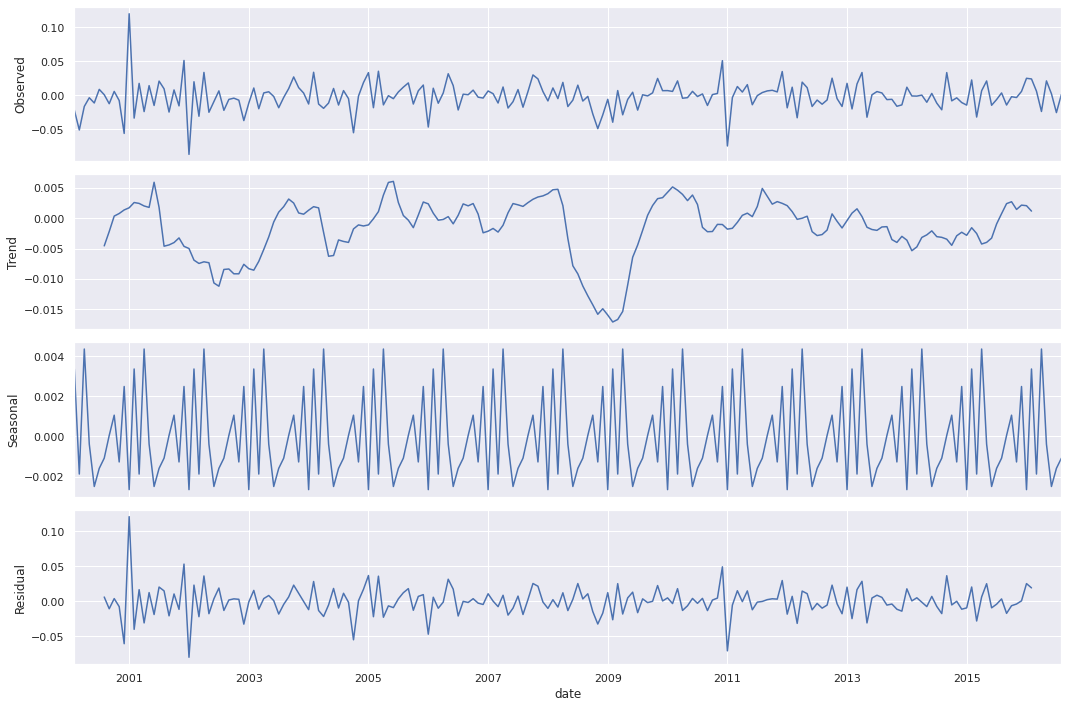

In [68]:
# Ещё раз дифференцируем
truncated_data['D1_d1'] = truncated_data.D1 - truncated_data.D1.shift(1)
sm.tsa.seasonal_decompose(truncated_data.D1_d1.dropna()).plot();
print(f'p-value критерия Дики-Фуллера: {round(sm.tsa.stattools.adfuller(truncated_data.D1_d1.dropna())[1], 4)}')

Здесь вполне достаточно одного сезонного и одного обычного дифференцирования

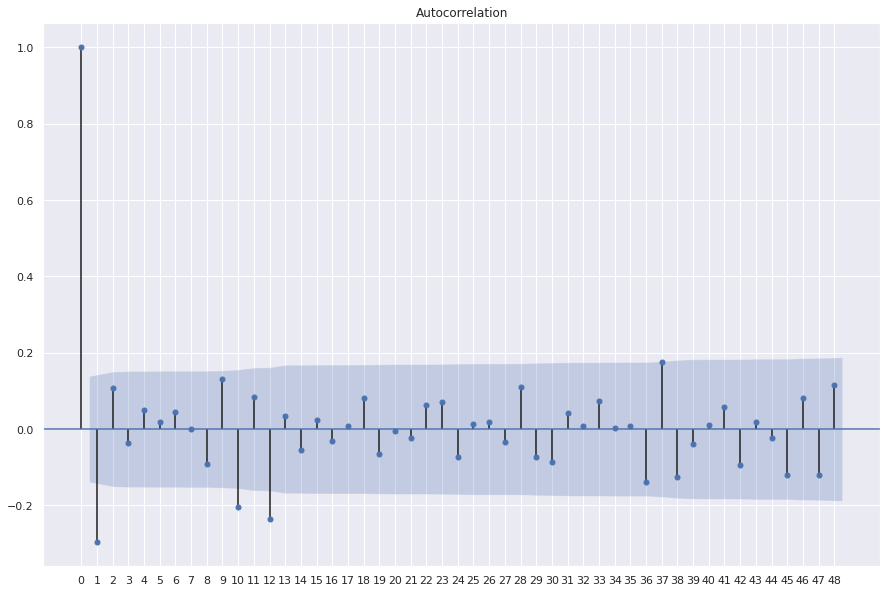

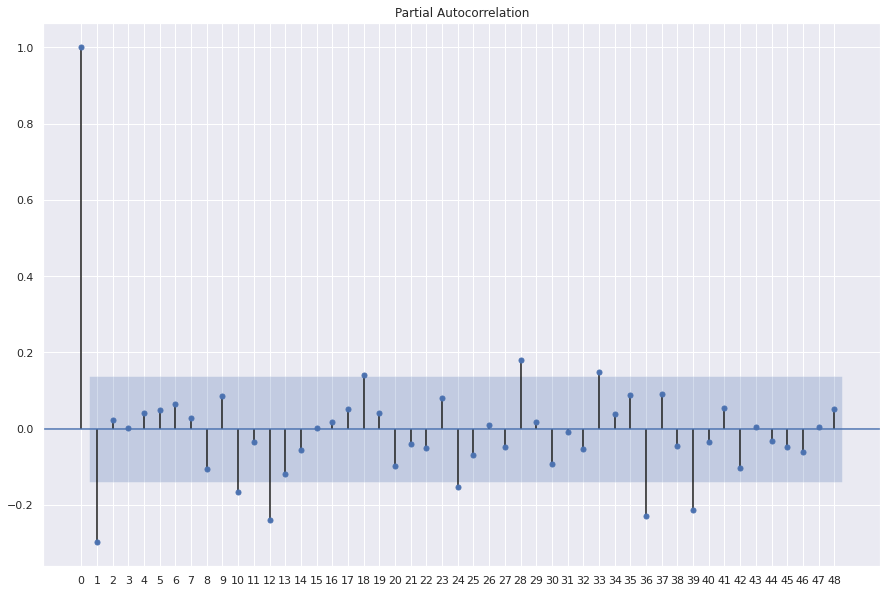

In [70]:
sm.graphics.tsa.plot_acf(truncated_data.D1_d1.dropna(), lags=48);
plt.xticks(range(49));
sm.graphics.tsa.plot_pacf(truncated_data.D1_d1.dropna(), lags=48);
plt.xticks(range(49));

Q=1, q=10, P=3, p=10

In [71]:
D = 1
d = 1
Qs = range(2)
qs = range(11)
Ps = range(4)
ps = range(11)
params = itertools.product(ps, qs, Ps, Qs)
params_list = list(params)
len(params_list)

968

In [72]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(params_list):
    model = sm.tsa.statespace.SARIMAX(truncated_data.t, order=(param[0], d, param[1]), 
                                    seasonal_order=(param[2], D, param[3], 12), enforce_stationarity=False,
                                    enforce_invertibility=False).fit()
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, aic])

warnings.filterwarnings('default')

100%|██████████| 968/968 [2:11:56<00:00,  8.18s/it]


In [73]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
184,"(2, 1, 0, 0)",-967.249900
176,"(2, 0, 0, 0)",-966.773280
96,"(1, 1, 0, 0)",-966.739318
88,"(1, 0, 0, 0)",-966.688310
8,"(0, 1, 0, 0)",-966.039136


In [74]:
# Посмотрим на лучшую модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  t   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood                 487.625
Date:                            Fri, 07 Aug 2020   AIC                           -967.250
Time:                                    11:18:41   BIC                           -954.117
Sample:                                01-01-1999   HQIC                          -961.934
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2415      0.555      0.435      0.663      -0.846       1.329
ar.L2          0.2005      0.173   

Критерий Стьюдента: p=0.1672371239442116
Критерий Дики-Фуллера: p=9.537449161618053e-07


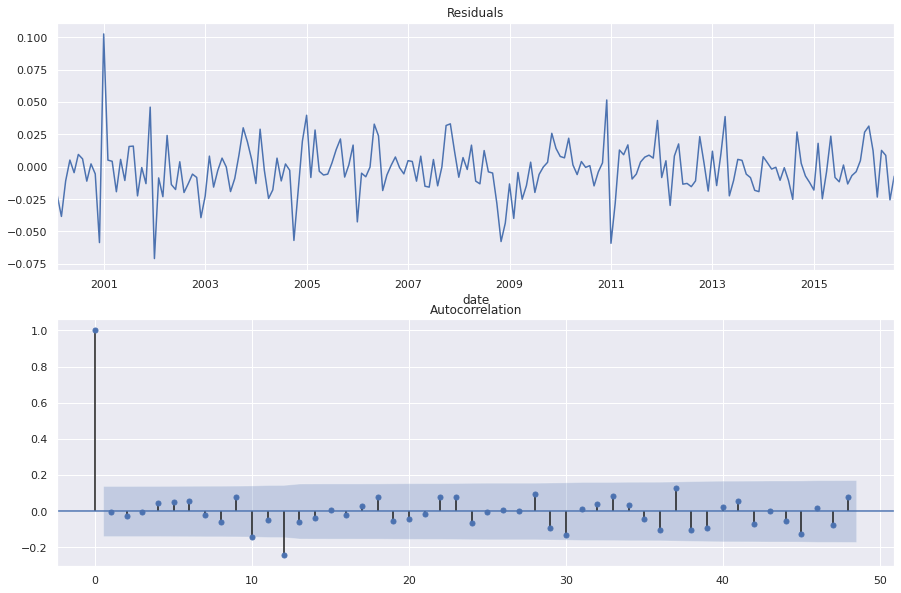

In [76]:
plt.subplot(2, 1, 1)
best_model.resid[13:].plot();
plt.title('Residuals')
ax = plt.subplot(2, 1, 2)
sm.tsa.graphics.plot_acf(best_model.resid[13:], lags=48, ax=ax);
print(f'Критерий Стьюдента: p={stats.ttest_1samp(best_model.resid[14:], 0)[1]}')
print(f'Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(best_model.resid[14:])[1]}')

Критерий Стьюдента говорит о том, что остатки несмещены, а критерий Дики-Фуллера, что остатки стационарны. На коррелограмме видно, что есть один значимый лаг, который вероятно стал значим случайно. Критерий Льюнга-Бокса говорит, что остатки неавтокоррелированы.

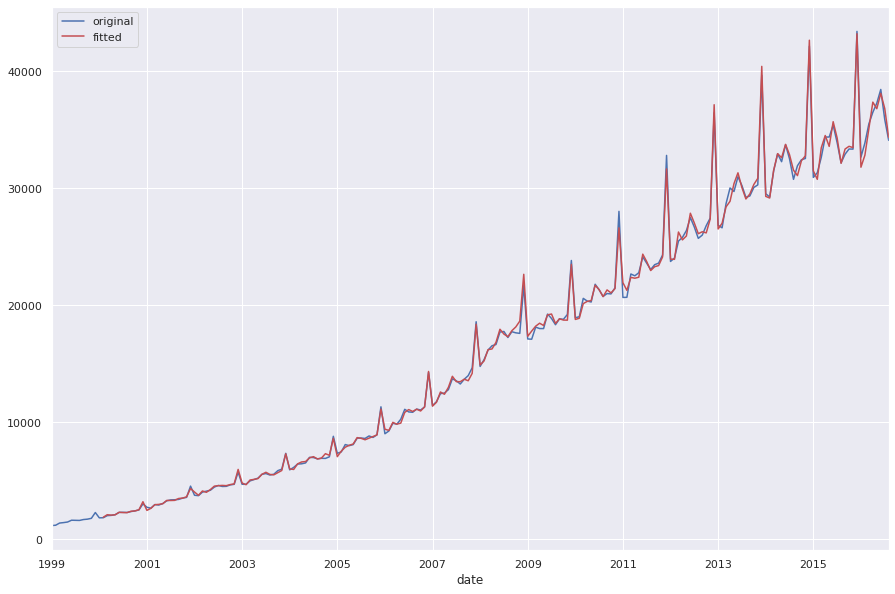

In [77]:
truncated_data.salary.plot(label='original')
special.inv_boxcox(best_model.fittedvalues[13:], lmbda).plot(color='r', label='fitted')
plt.legend();

Модель хорошо описывает имеющиеся данные

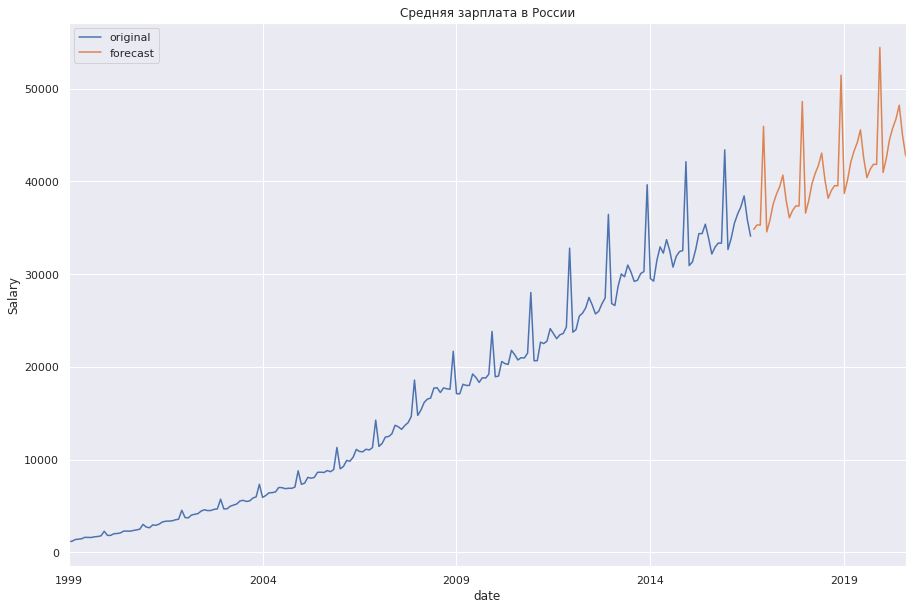

In [78]:
start = truncated_data.index[-1] + pd.DateOffset(months=1)
end = pd.to_datetime('01.08.2020', dayfirst=True)
predictions = special.inv_boxcox(best_model.predict(start=start, end=end), lmbda)
truncated_data.salary.plot(label='original')
predictions.plot(label='forecast')
plt.title('Средняя зарплата в России')
plt.ylabel('Salary')
plt.legend();

In [86]:
dates = pd.date_range(start=start, end=pd.to_datetime('01.05.2020', dayfirst=True), freq='MS')
new_salary = pd.read_csv('new.txt', header=None)
new_salary.index = dates
new_salary.columns = ['new_salary']
new_salary.rename_axis(index='date', inplace=True)

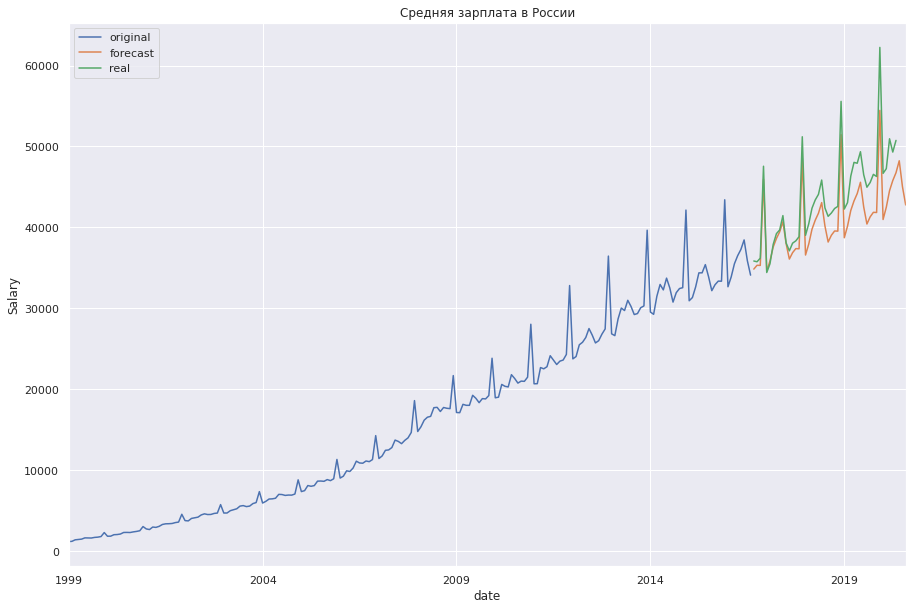

In [87]:
truncated_data.salary.plot(label='original')
predictions.plot(label='forecast')
new_salary.new_salary.plot(label='real', color='g')
plt.title('Средняя зарплата в России')
plt.ylabel('Salary')
plt.legend();

На урезанных данных модель себя ведёт намного лучше. Прогноз на первый год почти идеален, но дальше видна небольшая расходимость.